In [1]:
from spatialSSL.Dataloader import FullImageDatasetConstructor
from spatialSSL.Utils import split_dataset
from spatialSSL.Training import train
from spatialSSL.Training import train_epoch
from spatialSSL.Testing import test
from spatialSSL.Dataset import InMemoryGraphDataset
import numpy as np

/home/cheng-wei_liao/miniconda3/envs/master_prak/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/cheng-wei_liao/miniconda3/envs/master_prak/lib/python3.11/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
'''
import os
import scanpy as sc

adata = sc.read("./data/atlas_brain_638850_CCF.h5ad")
# subset the adata
selected_img = np.unique(adata.obs["section"])[0:20]
sub_adata = adata[adata.obs["section"].isin(selected_img)].copy()

# specify the output directory and file
output_dir = './data'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'sub_20img_adata.h5ad')

# write the sub_adata into a .h5ad file
sub_adata.write(output_file)
'''

'\nimport os\nimport scanpy as sc\n\nadata = sc.read("./data/atlas_brain_638850_CCF.h5ad")\n# subset the adata\nselected_img = np.unique(adata.obs["section"])[0:20]\nsub_adata = adata[adata.obs["section"].isin(selected_img)].copy()\n\n# specify the output directory and file\noutput_dir = \'./data\'\nos.makedirs(output_dir, exist_ok=True)\noutput_file = os.path.join(output_dir, \'sub_20img_adata.h5ad\')\n\n# write the sub_adata into a .h5ad file\nsub_adata.write(output_file)\n'

In [2]:
# Create an instance of Full_image_dataloader

 
#file_path = "./data/img_119670929.h5ad"
file_path = "./data/subset_6img_atlas_brain.h5ad"
#file_path = "./data/atlas_brain_638850_CCF.h5ad"
#file_path = "./data/sub_20img_adata.h5ad"

data_constracter = FullImageDatasetConstructor(file_path=file_path,
                                        image_col="section",
                                        label_col="class_label",
                                        include_label=False,
                                        radius=30,
                                        node_level = 1,
                                        use_edge_weight = True,
                                       #mask_method = "niche",
                                       #    niche_to_mask = 100
                                       #celltype_to_mask = "LQ"
                                               )


In [3]:
# Load the data
data_constracter.load_data()

In [4]:
# Construct the graph
graph_list = data_constracter.construct_graph()

/home/cheng-wei_liao/work/test/spatial_atlas_ssl/spatialSSL/Dataloader.py:231: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.adata.obs['cell_type_encoded'] = encode_cell_type.transform(self.adata.obs[self.label_col].values)


Constructing Graphs:   0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
graph_list

[Data(x=[26230, 550], edge_index=[2, 234482], edge_attr=[26230, 26230], y=[2623, 550], mask=[26230], cell_type=[26230], cell_type_masked=[2623], image='1199650929', num_nodes=26230),
 Data(x=[29300, 550], edge_index=[2, 259136], edge_attr=[29300, 29300], y=[2930, 550], mask=[29300], cell_type=[29300], cell_type_masked=[2930], image='1199650932', num_nodes=29300),
 Data(x=[36043, 550], edge_index=[2, 250394], edge_attr=[36043, 36043], y=[3604, 550], mask=[36043], cell_type=[36043], cell_type_masked=[3604], image='1199650935', num_nodes=36043),
 Data(x=[47461, 550], edge_index=[2, 410372], edge_attr=[47461, 47461], y=[4746, 550], mask=[47461], cell_type=[47461], cell_type_masked=[4746], image='1199650938', num_nodes=47461),
 Data(x=[51012, 550], edge_index=[2, 419170], edge_attr=[51012, 51012], y=[5101, 550], mask=[51012], cell_type=[51012], cell_type_masked=[5101], image='1199650941', num_nodes=51012),
 Data(x=[50899, 550], edge_index=[2, 408008], edge_attr=[50899, 50899], y=[5089, 550]

In [6]:
'''
# Replace 'data_constracter.adata.obs' with your actual DataFrame variable.
class_label_counts = data_constracter.adata.obs["class_label"].value_counts().reset_index()
class_label_counts.columns = ["class_label", "count"]
class_label_counts = class_label_counts.sort_values(by="count", ascending=False)
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Set Seaborn style
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot the bars
plt.bar(class_label_counts["class_label"], class_label_counts["count"])

# Add labels and title
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Label Counts")

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90, ha='right')

# Display the plot
plt.tight_layout()
plt.show()
'''

'\n# Replace \'data_constracter.adata.obs\' with your actual DataFrame variable.\nclass_label_counts = data_constracter.adata.obs["class_label"].value_counts().reset_index()\nclass_label_counts.columns = ["class_label", "count"]\nclass_label_counts = class_label_counts.sort_values(by="count", ascending=False)\nplt.figure(figsize=(10, 6))  # Adjust the figure size as needed\n\n# Set Seaborn style\nsns.set_style("whitegrid")\n\nplt.figure(figsize=(10, 6))  # Adjust the figure size as needed\n\n# Plot the bars\nplt.bar(class_label_counts["class_label"], class_label_counts["count"])\n\n# Add labels and title\nplt.xlabel("Class Label")\nplt.ylabel("Count")\nplt.title("Class Label Counts")\n\n# Rotate x-axis labels for better readability (optional)\nplt.xticks(rotation=90, ha=\'right\')\n\n# Display the plot\nplt.tight_layout()\nplt.show()\n'

In [7]:
'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data_constracter.adata.obs' is your DataFrame
class_label_counts = data_constracter.adata.obs["class_label"].value_counts().reset_index()
class_label_counts.columns = ["class_label", "count"]
class_label_counts = class_label_counts.sort_values(by="count", ascending=False)

# Set Seaborn style
sns.set_style("whitegrid")

# Create the bar plot using Seaborn with blue color
plt.figure(figsize=(10, 6))
sns.barplot(x="class_label", y="count", data=class_label_counts, color="blue")

# Add labels and title
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Label Counts")

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()
'''

'\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Assuming \'data_constracter.adata.obs\' is your DataFrame\nclass_label_counts = data_constracter.adata.obs["class_label"].value_counts().reset_index()\nclass_label_counts.columns = ["class_label", "count"]\nclass_label_counts = class_label_counts.sort_values(by="count", ascending=False)\n\n# Set Seaborn style\nsns.set_style("whitegrid")\n\n# Create the bar plot using Seaborn with blue color\nplt.figure(figsize=(10, 6))\nsns.barplot(x="class_label", y="count", data=class_label_counts, color="blue")\n\n# Add labels and title\nplt.xlabel("Class Label")\nplt.ylabel("Count")\nplt.title("Class Label Counts")\n\n# Rotate x-axis labels for better readability (optional)\nplt.xticks(rotation=45, ha=\'right\')\n\n# Display the plot\nplt.tight_layout()\nplt.show()\n'

In [8]:
train_loader, val_loader, test_loader = split_dataset(graph_list,split_percent=(0.6, 0.3, 0.1), batch_size=1)

In [9]:
# Print out the size of each set to verify
print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Train size: 3
Validation size: 1
Test size: 2


In [10]:
for x in train_loader:
    print(x.y.shape)
    print(x.x.shape)
    break

torch.Size([4746, 550])
torch.Size([47461, 550])


In [11]:
# Assuming gene_expression is your target variable after masking
#variance_after_masking = torch.var(x.y.to_dense().float())
#print("Variance after masking:", variance_after_masking.item())

In [25]:
from torch import nn, optim, Tensor
import torch
from torch_geometric.nn import GCNConv,GATConv
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import r2_score
from torch.nn import LeakyReLU, Dropout
import time
from torch.utils.checkpoint import checkpoint


class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    
class GCN_1(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)

        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.act(self.conv1(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    
class GCN_2(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = checkpoint(self.conv2, x, edge_index)
        x = self.act(self.conv3(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x

class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, out_channels)
        self.conv4 = GATConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    
class GAT_3(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2( x, edge_index)))
        x = self.act(self.conv3(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    

In [22]:
import torch
from torch import nn, optim
import time
from torcheval.metrics import MeanSquaredError,R2Score


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_epoch(model, loader, optimizer, criterion,r2_metric, mse_metric, gene_expression=None, training=True):

    
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0

    with torch.set_grad_enabled(training):
        for data in loader:

            if training:
                optimizer.zero_grad()

            if gene_expression is None:
                #input =  torch.tensor(data.x, dtype=torch.float).to(device)
                #input_masked = torch.tensor(data.y, dtype=torch.float).to(device)
                
                target = data.y.float().to_dense()
                
                outputs = model(data.x.float().to(device), data.edge_index.long().to(device))
                loss = criterion(outputs[data.mask],target.to(device))
                
                # evaluate metrics

                r2_metric.update(outputs[data.mask].cpu(),target.cpu())
                mse_metric.update(outputs[data.mask].cpu(),target.cpu())

            else:
                input = torch.tensor(gene_expression[data.x].toarray(), dtype=torch.double).to(device)
                input[data.mask] = 0
                target = torch.tensor(gene_expression[data.y].toarray(), dtype=torch.double).to(device)
                outputs = model(input.float(), data.edge_index.to(device).long())
                loss = criterion(outputs[data.mask], target.float())

            if training:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * data.num_graphs

    return total_loss / len(loader.dataset), r2_metric.compute(),mse_metric.compute()

def train(model, train_loader, val_loader, criterion, num_epochs=100, patience=5, optimizer = None,model_path=None,
          gene_expression=None, minibatch = False):

    r2_metric_train = R2Score()
    r2_metric_val = R2Score()
    mse_metric_train = MeanSquaredError()
    mse_metric_val = MeanSquaredError()
    
    model.to(device)
    best_val_loss = float('inf')
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_r2,train_mse = train_epoch(model, train_loader, optimizer, criterion,r2_metric_train, mse_metric_train, gene_expression, training=True)
        val_loss, val_r2, val_mse = train_epoch(model, val_loader, optimizer,criterion ,r2_metric_val,mse_metric_val, gene_expression, training=False)
        # scheduler.step() # Decrease learning rate by scheduler

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            epochs_no_improve = 0
            if model_path is not None:
                torch.save(model.state_dict(), model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print('Early stopping!')
                break

        print(
            f"Epoch {epoch + 1}/{num_epochs}, train loss: {train_loss:.4f}, train r2: {train_r2:.4f}, train mse: {train_mse:.4f},  val loss: {val_loss:.4f}, val r2: {val_r2:.4f}, val mse: {val_mse:.4f}, Time: {time.time() - start_time:.4f}s")

    print(f"Best val loss: {best_val_loss:.4f}, at epoch {best_epoch + 1}")

In [28]:
# Pretraining
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the model
model = GAT_3(550, 550, 550).to(device) # in_channels is set to 100 as an example. Please replace it with your actual feature size.

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
#scheduler = StepLR(optimizer, step_size=80, gamma=0.1) # learning rate scheduler

num_epochs = 150
patience = 8

train(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, num_epochs= num_epochs, patience = patience, optimizer= optimizer,model_path = './models/GAT_3_6img_model.pt')

Epoch 1/150, train loss: 0.9325, train r2: -0.4095, train mse: 0.9505,  val loss: 0.8740, val r2: -0.2333, val mse: 0.8740, Time: 0.6845s
Epoch 2/150, train loss: 0.7812, train r2: -0.3299, train mse: 0.8661,  val loss: 0.7607, val r2: -0.1746, val mse: 0.8173, Time: 0.6737s
Epoch 3/150, train loss: 0.7038, train r2: -0.2661, train mse: 0.8148,  val loss: 0.7106, val r2: -0.1424, val mse: 0.7817, Time: 0.6619s
Epoch 4/150, train loss: 0.6621, train r2: -0.2204, train mse: 0.7777,  val loss: 0.6805, val r2: -0.1210, val mse: 0.7564, Time: 0.7383s
Epoch 5/150, train loss: 0.6352, train r2: -0.1889, train mse: 0.7504,  val loss: 0.6511, val r2: -0.1038, val mse: 0.7354, Time: 0.6671s
Epoch 6/150, train loss: 0.6115, train r2: -0.1647, train mse: 0.7281,  val loss: 0.6265, val r2: -0.0892, val mse: 0.7172, Time: 0.6646s
Epoch 7/150, train loss: 0.5910, train r2: -0.1450, train mse: 0.7091,  val loss: 0.6047, val r2: -0.0764, val mse: 0.7012, Time: 0.6609s
Epoch 8/150, train loss: 0.5746, t

In [48]:
#Load model

# Loading the Model
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recreate the model structure (it should match the saved model)
model = GCN_1(550, 550, 550).to(device)

# Load the saved model weights
model_path = './models/model.pt'
model.load_state_dict(torch.load(model_path))
model.eval() # Set the model in evaluation mode

# Downstream Tasks
# For example, let's predict on a test set

# Loading test data
# Replace this line with the appropriate code to load your test data
test_loader

# Evaluating the model on the test set

with torch.no_grad():
    for data in test_loader:

        target = data.y.float().to_dense()

        outputs = model(data.x.float().to(device), data.edge_index.long().to(device))
        loss = criterion(outputs[data.mask],target.to(device))
        
        print(loss)






tensor(1.0352, device='cuda:0')
tensor(0.9649, device='cuda:0')


In [15]:
for x in test_loader:
    print(x)

DataBatch(x=[26230, 550], edge_index=[2, 412826], y=[2623, 550], mask=[26230], cell_type=[1], cell_type_masked=[1], image=[1], num_nodes=26230, batch=[26230], ptr=[2])
DataBatch(x=[47461, 550], edge_index=[2, 709388], y=[4746, 550], mask=[47461], cell_type=[1], cell_type_masked=[1], image=[1], num_nodes=47461, batch=[47461], ptr=[2])


In [29]:
from tqdm.auto import tqdm
def test(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    
    total_test_loss = 0
    test_targets_list = []
    test_outputs_list = []
    test_celltypes_list = []

    for data in tqdm(test_loader):
        with torch.no_grad():

            outputs = model(data.x.float().to(device), data.edge_index.to(device).long())
            loss = criterion(outputs[data.mask], data.y.float())
        total_test_loss += loss.item() * data.num_graphs
        test_celltypes_list.append(data.cell_type_masked)
        test_targets_list.append(expression_masked.float())
        test_outputs_list.append(outputs[data.mask])

    # Measure and print test loss and R2
    test_loss = total_test_loss / len(test_loader.dataset)
    test_r2 = r2_score(torch.cat(test_targets_list).cpu().detach().numpy(),
                       torch.cat(test_outputs_list).cpu().detach().numpy())
    print(f"Test loss: {test_loss:.4f}, test r2: {test_r2:.4f}")
        # Return test loss and r2 for further use
    return test_loss, test_r2,test_targets_list,test_outputs_list,test_celltypes_list

In [40]:

def test(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    
    total_test_loss = 0
    test_targets_list = []
    test_outputs_list = []
    test_celltypes_list = []

    for data in tqdm(test_loader):
        with torch.no_grad():
            
            outputs = model(data.x.float().to(device), data.edge_index.to(device).long())
            loss = criterion(outputs[data.mask], data.y.to_dense().to(device))
        total_test_loss += loss.item() * data.num_graphs
        test_celltypes_list.append(data.cell_type_masked)
        test_targets_list.append(data.y.to_dense().float())
        test_outputs_list.append(outputs[data.mask])

    # Measure and print test loss and R2
    test_loss = total_test_loss / len(test_loader.dataset)
    test_r2 = r2_score(torch.cat(test_targets_list).cpu().detach().numpy(),
                       torch.cat(test_outputs_list).cpu().detach().numpy())
    print(f"Test loss: {test_loss:.4f}, test r2: {test_r2:.4f}")
        # Return test loss and r2 for further use
    return test_loss, test_r2,test_targets_list,test_outputs_list,test_celltypes_list

In [41]:
test_loss, test_r2,test_targets_list,test_outputs_list,test_celltypes_list = test(model, test_loader, criterion, device)

  0%|          | 0/2 [00:00<?, ?it/s]

Test loss: 0.4612, test r2: 0.1135


In [42]:
len(test_celltypes_list)

2

In [44]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# usage
model = GCN_2(550, 550, 550)  # Replace with your actual model
print(f'The model has {count_parameters(model):,} parameters')


The model has 909,150 parameters


In [45]:
import itertools
# Flatten the nested list into a single-dimensional list
flattened_list = list(itertools.chain.from_iterable(test_celltypes_list))
flattened_list = list(itertools.chain.from_iterable(flattened_list))

In [46]:
len(test_targets_list)

2

In [47]:
len(torch.cat(test_targets_list).cpu().detach().numpy())

10190

In [48]:
len(torch.cat(test_targets_list).cpu().detach().numpy())

10190

In [49]:
print(len(flattened_list))
print(len(r2_score(np.transpose(torch.cat(test_targets_list).cpu().detach().numpy()), np.transpose(torch.cat(test_outputs_list).cpu().detach().numpy()), multioutput='raw_values')))

10190
10190


In [85]:
flattened_list[0:5]

['MOB-DG-IMN', 'IT-ET Glut', 'MGE GABA', 'MGE GABA', 'Vascular']

In [86]:
data_constracter.adata.var_names[0:5]

Index(['Prkcq', 'Col5a1', 'Grik3', 'Igfbp2', 'Osr1'], dtype='object')

In [93]:
print(len(np.transpose(torch.cat(test_targets_list).cpu().detach().numpy())))
np.transpose(torch.cat(test_targets_list).cpu().detach().numpy())

550


array([[0.        , 0.        , 0.        , ..., 1.5191313 , 0.        ,
        1.1785693 ],
       [0.        , 0.5433028 , 1.3851362 , ..., 0.        , 0.        ,
        0.        ],
       [1.9734081 , 3.4064555 , 2.731592  , ..., 0.95091033, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.3851362 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [92]:
print(len(torch.cat(test_targets_list).cpu().detach().numpy()))
torch.cat(test_targets_list).cpu().detach().numpy()

102696


array([[0.        , 0.        , 1.9734081 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.5433028 , 3.4064555 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.3851362 , 2.731592  , ..., 0.        , 1.3851362 ,
        0.        ],
       ...,
       [1.5191313 , 0.        , 0.95091033, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.1785693 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [50]:
import pandas as pd

preds_test_per_cell = pd.DataFrame({'celltype': flattened_list, 'r2_score': r2_score(np.transpose(torch.cat(test_targets_list).cpu().detach().numpy()), np.transpose(torch.cat(test_outputs_list).cpu().detach().numpy()), multioutput='raw_values')})

preds_test_per_gene = pd.DataFrame({'gene': data_constracter.adata.var_names, 'r2_score': r2_score(torch.cat(test_targets_list).cpu().detach().numpy(), torch.cat(test_outputs_list).cpu().detach().numpy(), multioutput='raw_values')})



In [51]:
preds_test_per_cell[0:5]

,celltype,r2_score
0,1,0.755812
1,16,0.277310
2,0,0.489664
3,1,0.393608
4,0,0.411930


In [52]:
preds_test_per_gene[0:5]

,gene,r2_score
0,Prkcq,0.158854
1,Col5a1,0.207687
2,Grik3,0.288107
3,Igfbp2,0.355741
4,Osr1,0.230536


In [53]:
# huge class inbalance problem, need to handel -> add weight?
# add pooling

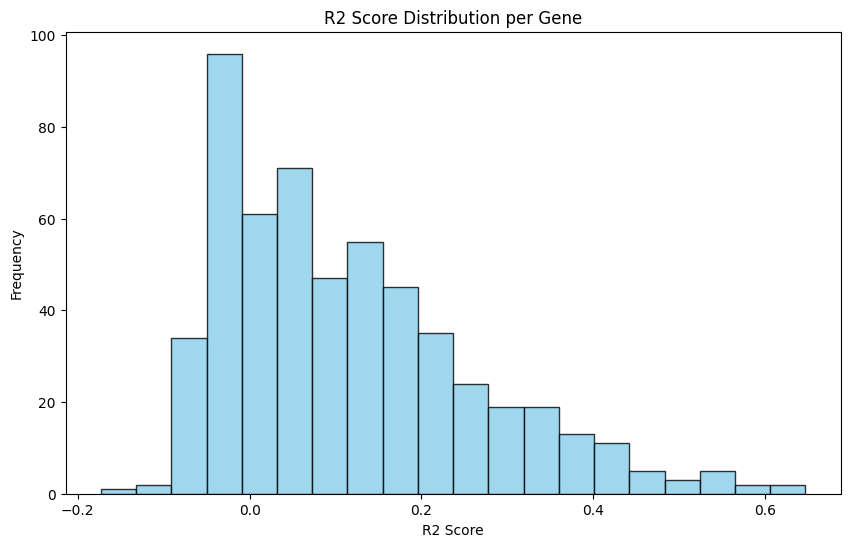

         gene  r2_score
49      Pvalb  0.646933
31       Gfap  0.610155
10      Calb1  0.601062
293   Ppp1r17  0.597634
214   Slc17a7  0.553041
..        ...       ...
522  Blank-40 -0.085842
294     Dmrt2 -0.086027
119      Fli1 -0.091145
308      Casr -0.099311
138    Fibcd1 -0.173082

[550 rows x 2 columns]


In [54]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10,6))
plt.hist(preds_test_per_gene['r2_score'], bins=20, alpha=0.8, color='skyblue', edgecolor='black')
plt.title('R2 Score Distribution per Gene')
plt.xlabel('R2 Score')
plt.ylabel('Frequency')
plt.show()

# Sorting by r2_score
preds_test_per_gene = preds_test_per_gene.sort_values(by='r2_score', ascending=False)

# Display the sorted DataFrame
print(preds_test_per_gene)


,gene,r2_score
49,Pvalb,0.646933
31,Gfap,0.610155
10,Calb1,0.601062
293,Ppp1r17,0.597634
214,Slc17a7,0.553041
...,...,...
522,Blank-40,-0.085842
294,Dmrt2,-0.086027
119,Fli1,-0.091145
308,Casr,-0.099311


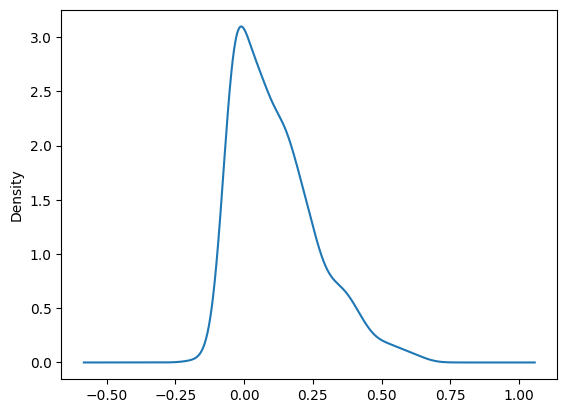

In [55]:
preds_test_per_gene

# plot r2 score distribution per gene, histogram
# density plot
preds_test_per_gene.r2_score.plot.kde()
#preds_test_per_gene.r2_score.plot.hist(bins=20, alpha=0.8)

# plot r2 score distribution per celltype, histogram
#preds_test_per_cell.r2_score.plot.hist(bins=10, alpha=0.8)

# sort by r2 score
preds_test_per_gene.sort_values(by='r2_score', ascending=False, inplace=True)
preds_test_per_gene

In [28]:
preds_test_per_cell

,celltype,r2_score
0,MOB-DG-IMN,0.495735
1,IT-ET Glut,0.375281
2,MGE GABA,0.395603
3,MGE GABA,0.372851
4,Vascular,0.339388
...,...,...
102691,Oligo,0.613253
102692,IT-ET Glut,-0.135538
102693,Oligo,0.111933
102694,Oligo,0.115551


In [54]:
import torch

# Replace 'model.pt' with the actual file path of your model
model_path = "./models/model_fillomgGAT2.pt"

# Define your model architecture (make sure it matches the architecture used to save the model)
# Example: If you have a class named 'MyModel', you would need to create an instance of it first.
# model = MyModel()

# Load the model from the file
state_dict = torch.load(model_path)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# If you saved the model on a GPU and want to use it on the CPU, use the following line:
# state_dict = torch.load(model_path, map_location=torch.device('cpu'))
# model.load_state_dict(state_dict)

# Put the model in evaluation mode if it contains dropout, batch norm, etc.
model.eval()

AttributeError: 'collections.OrderedDict' object has no attribute 'load_state_dict'

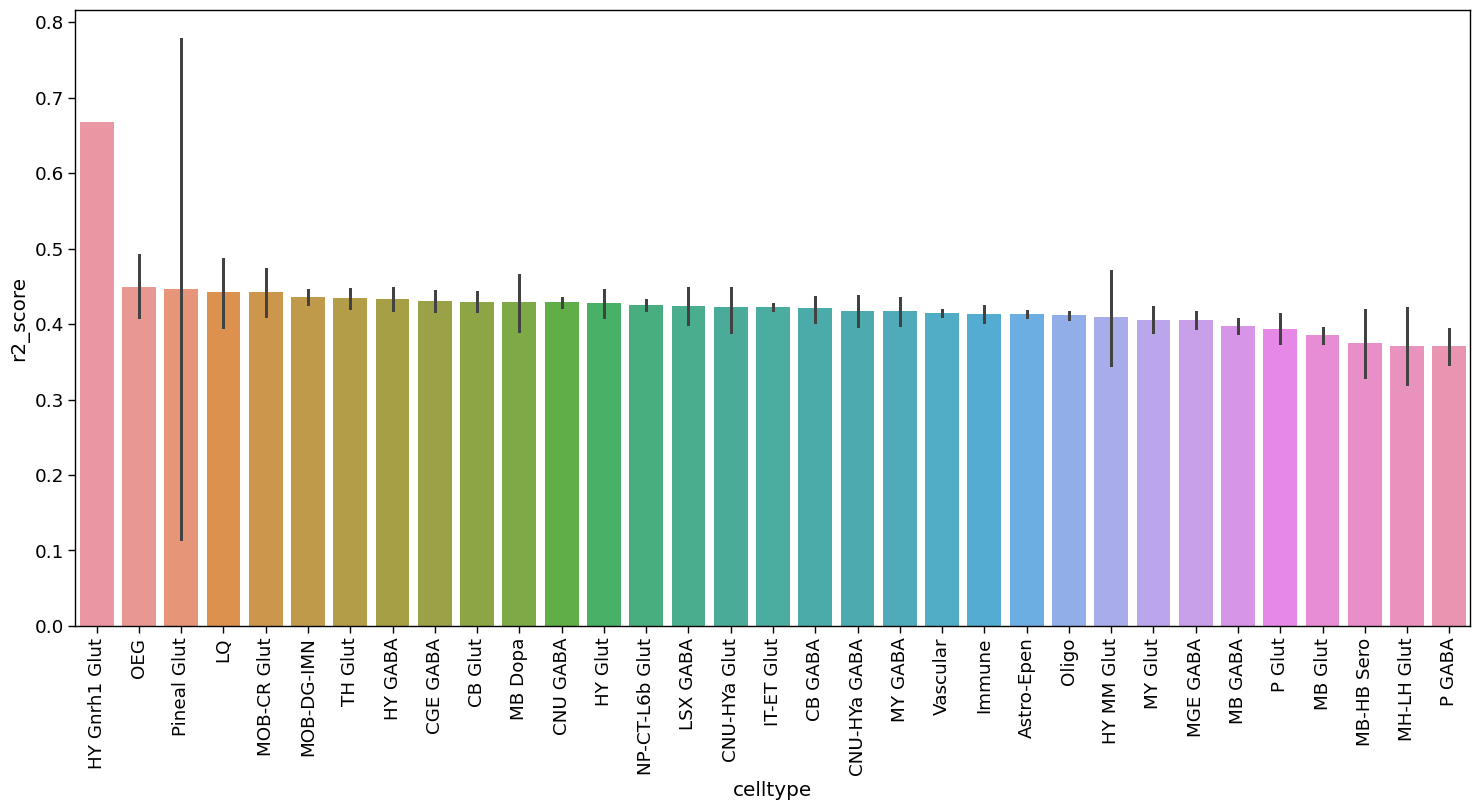

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# set style
sns.set_palette("colorblind")
sns.set_context("paper", font_scale=1.5)

# make plot larger
plt.figure(figsize=(18,8))

# rotate x-axis labels
plt.xticks(rotation=90)

# create plot of mean R2 score per celltype
# order bars by mean R2 score

# add avlue counts from adata.obs.class_label.value_counts()
ax = sns.barplot(x="celltype", y="r2_score", data=preds_test_per_cell, order=preds_test_per_cell.groupby('celltype').mean().sort_values(by='r2_score', ascending=False).index)

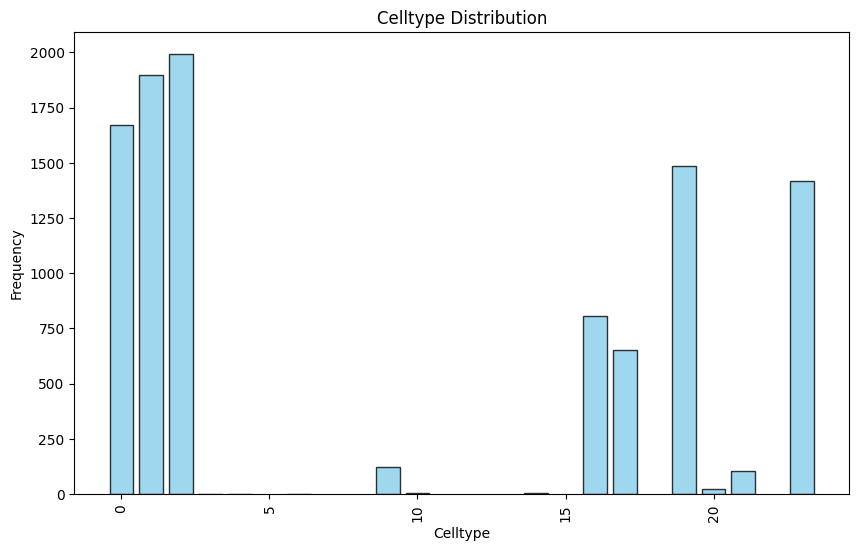

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the frequency of each celltype
celltype_counts = preds_test_per_cell['celltype'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(celltype_counts.index, celltype_counts.values, alpha=0.8, color='skyblue', edgecolor='black')
plt.xticks(rotation='vertical')
plt.xticks(rotation=90)
plt.title('Celltype Distribution')
plt.xlabel('Celltype')
plt.ylabel('Frequency')
plt.show()


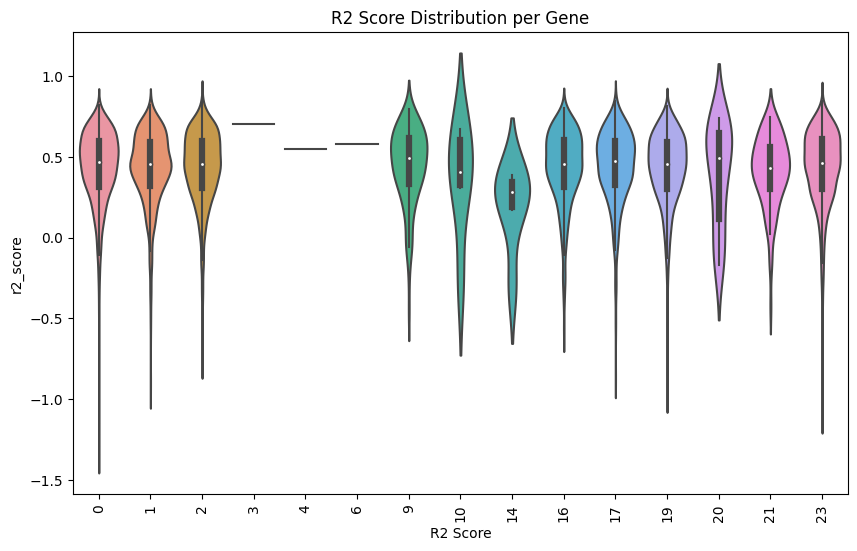

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.violinplot(x="celltype", y="r2_score", data=preds_test_per_cell)
# rotate x-axis labels
plt.xticks(rotation=90)
plt.title('R2 Score Distribution per Gene')
plt.xlabel('R2 Score')
plt.show()


In [66]:
file_path = "./data/subset_6img_atlas_brain.h5ad"
root_path = "./data"
dataset = InMemoryGraphDataset(root= root_path,
                               data_names = "data_test",
                               file_path=file_path, image_col="section", label_col="class_label", include_label=False, radius=20,node_level = 1, batch_size=1)



Processing...


AttributeError: 'InMemoryGraphDataset' object has no attribute 'data_loader'

In [ ]:
# Load your dataset
import torch
data = torch.load('./data/data_test.pt')